# Feature engineering

In [2]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# load cleaned data
df = pd.read_csv('c_data.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

,loan_amnt,credit_month,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range,inq_last_6mths,open_acc,revol_bal,total_acc,pub_rec_bankruptcies
0,5000.0,36,0.1065,B,B2,10.0,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,27.65,0.0,1985-01-01,735.0,1.0,3.0,13648.0,9.0,0.0
1,2500.0,60,0.1527,C,C4,0.0,RENT,30000.0,Source Verified,2011-12-01,Charged Off,other,1.00,0.0,1999-04-01,740.0,5.0,3.0,1687.0,4.0,0.0
2,2400.0,36,0.1596,C,C5,10.0,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,other,8.72,0.0,2001-11-01,735.0,2.0,2.0,2956.0,10.0,0.0
3,10000.0,36,0.1349,C,C1,10.0,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,20.00,0.0,1996-02-01,690.0,1.0,10.0,5598.0,37.0,0.0
4,3000.0,60,0.1269,B,B5,1.0,RENT,80000.0,Source Verified,2011-12-01,Fully Paid,other,17.94,0.0,1996-01-01,695.0,0.0,15.0,27783.0,38.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             39786 non-null  float64
 1   credit_month          39786 non-null  int64  
 2   int_rate              39786 non-null  float64
 3   grade                 39786 non-null  object 
 4   sub_grade             39786 non-null  object 
 5   emp_length            38708 non-null  float64
 6   home_ownership        39786 non-null  object 
 7   annual_inc            39786 non-null  float64
 8   verification_status   39786 non-null  object 
 9   issue_d               39786 non-null  object 
 10  loan_status           39786 non-null  object 
 11  purpose               39786 non-null  object 
 12  dti                   39786 non-null  float64
 13  delinq_2yrs           39786 non-null  float64
 14  earliest_cr_line      39786 non-null  object 
 15  fico_range         

In [5]:
df.shape

(39786, 21)

In [8]:
# Find missing values
df.isnull().sum()[df.isnull().sum()>0]

emp_length              1078
pub_rec_bankruptcies     697
dtype: int64

<Axes: >

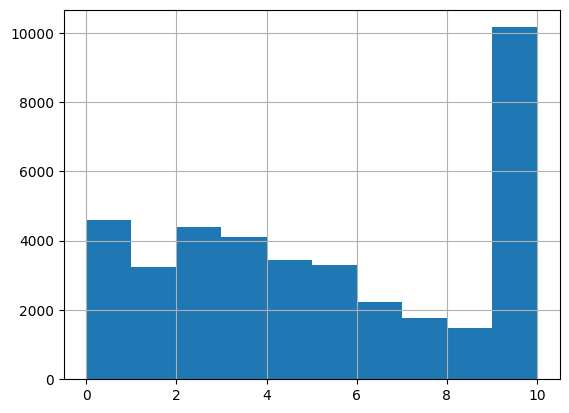

In [7]:
df['emp_length'].hist()

In [10]:
# Fill missing values with the most frequent value
df['emp_length'].fillna(df['emp_length'].value_counts()
.idxmax(), inplace=True)

<Axes: >

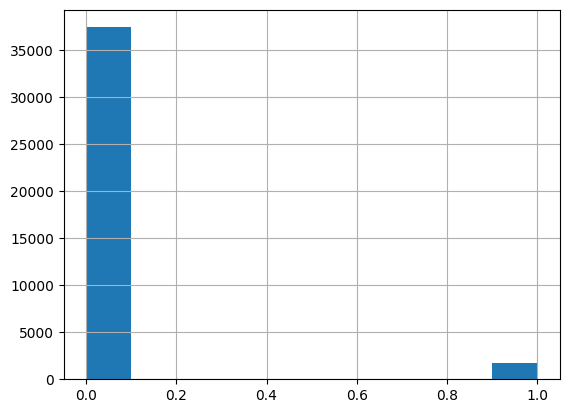

In [11]:
df['pub_rec_bankruptcies'].hist()

In [12]:
# Fill missing values with 1 or 0 based on the distribution
nan_count = df['pub_rec_bankruptcies'].isnull().sum()

# Count of NaN values
half_nans = nan_count // 2
remaining_nans = nan_count - half_nans

# Get indices of NaN values
nan_indices = df[df['pub_rec_bankruptcies'].isnull()].index

# Fill first half of NaN values with '0'
df.loc[nan_indices[:half_nans], 'pub_rec_bankruptcies'] = 0

# Fill second half of NaN values with '1'
df.loc[nan_indices[half_nans:half_nans + remaining_nans], 'pub_rec_bankruptcies'] = 1

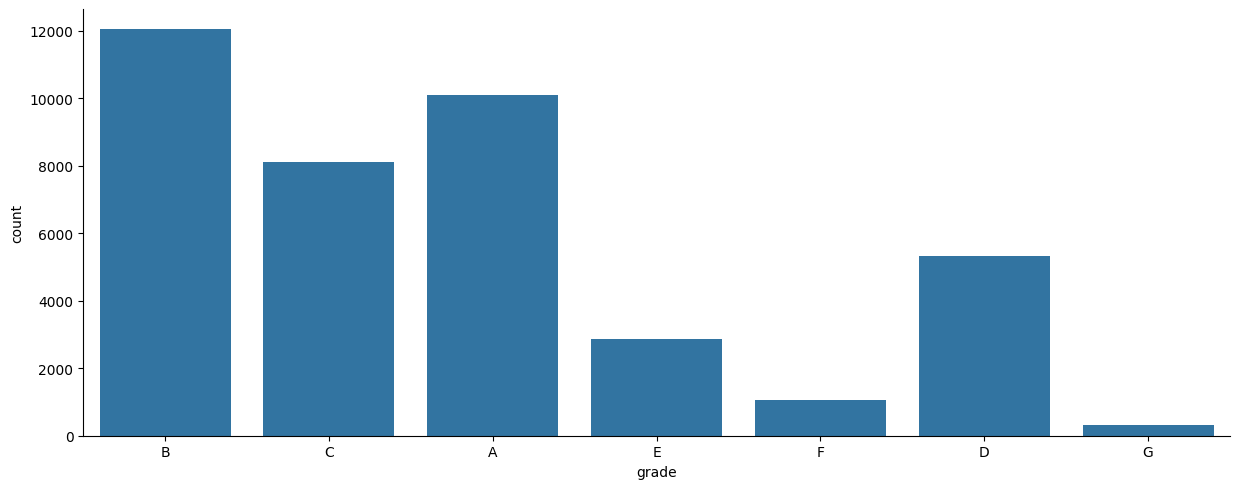

In [14]:
# Plot the distribution of the column "grade"
try:
    sns.catplot(x='grade', 
                data=df, 
                aspect=2.5, 
                kind='count')
except ValueError:
    pass  # pass error when the plot is already closed

In [15]:
# Convert the column "grade" to numerical values
df['grade'].replace({'A': 7,
                    'B' : 6,
                    'C' : 5,
                    'D' : 4,
                    'E' : 3,
                    'F' : 2,
                    'G' : 1}, inplace = True)

In [16]:
# Convert the column "sub_grade" to numerical values (A1 -> 7.1, A2 -> 7.2, ..., G5 -> 1.5)
df['sub_grade'] = df['sub_grade'].str[1:]
df['sub_grade'] = pd.to_numeric(df['sub_grade'])
# Create a new column "grade_numeric" by adding the columns "grade" and "sub_grade"
df['grade_numeric'] = df['grade']+ df['sub_grade']/10
df.drop(['sub_grade', 
                'grade'], axis=1, inplace = True)

In [17]:
# Convert the column "home_ownership" to numerical values
df['verification_status'].replace({'Verified':1, 
                                          'Source Verified':1, 
                                          'Not Verified':0}, inplace = True)
df['loan_status'].replace({'Fully Paid':1, 
                                  'Charged Off':0}, inplace = True)

In [18]:
df.head()

,loan_amnt,credit_month,int_rate,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range,inq_last_6mths,open_acc,revol_bal,total_acc,pub_rec_bankruptcies,grade_numeric
0,5000.0,36,0.1065,10.0,RENT,24000.0,1,2011-12-01,1,credit_card,27.65,0.0,1985-01-01,735.0,1.0,3.0,13648.0,9.0,0.0,6.2
1,2500.0,60,0.1527,0.0,RENT,30000.0,1,2011-12-01,0,other,1.00,0.0,1999-04-01,740.0,5.0,3.0,1687.0,4.0,0.0,5.4
2,2400.0,36,0.1596,10.0,RENT,12252.0,0,2011-12-01,1,other,8.72,0.0,2001-11-01,735.0,2.0,2.0,2956.0,10.0,0.0,5.5
3,10000.0,36,0.1349,10.0,RENT,49200.0,1,2011-12-01,1,other,20.00,0.0,1996-02-01,690.0,1.0,10.0,5598.0,37.0,0.0,5.1
4,3000.0,60,0.1269,1.0,RENT,80000.0,1,2011-12-01,1,other,17.94,0.0,1996-01-01,695.0,0.0,15.0,27783.0,38.0,0.0,6.5


In [19]:
# Convert the column "term" to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], format = '%Y-%m-%d')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format = '%Y-%m-%d')

In [20]:
# Create a new column "years_of_credit_history" by subtracting the column "earliest_cr_line" from the column "issue_d"
df['years_of_credit_history'] = round(((df['issue_d'] - df['earliest_cr_line']).dt.days/365), 1)
df.drop(['earliest_cr_line', 'issue_d'], axis=1, inplace = True)

In [21]:
df.head()

,loan_amnt,credit_month,int_rate,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,fico_range,inq_last_6mths,open_acc,revol_bal,total_acc,pub_rec_bankruptcies,grade_numeric,years_of_credit_history
0,5000.0,36,0.1065,10.0,RENT,24000.0,1,1,credit_card,27.65,0.0,735.0,1.0,3.0,13648.0,9.0,0.0,6.2,26.9
1,2500.0,60,0.1527,0.0,RENT,30000.0,1,0,other,1.00,0.0,740.0,5.0,3.0,1687.0,4.0,0.0,5.4,12.7
2,2400.0,36,0.1596,10.0,RENT,12252.0,0,1,other,8.72,0.0,735.0,2.0,2.0,2956.0,10.0,0.0,5.5,10.1
3,10000.0,36,0.1349,10.0,RENT,49200.0,1,1,other,20.00,0.0,690.0,1.0,10.0,5598.0,37.0,0.0,5.1,15.8
4,3000.0,60,0.1269,1.0,RENT,80000.0,1,1,other,17.94,0.0,695.0,0.0,15.0,27783.0,38.0,0.0,6.5,15.9


In [22]:
df.shape

(39786, 19)

Outliers

loan_amnt                     Axes(0.125,0.814746;0.168478x0.0652542)
credit_month               Axes(0.327174,0.814746;0.168478x0.0652542)
int_rate                   Axes(0.529348,0.814746;0.168478x0.0652542)
emp_length                 Axes(0.731522,0.814746;0.168478x0.0652542)
annual_inc                    Axes(0.125,0.736441;0.168478x0.0652542)
verification_status        Axes(0.327174,0.736441;0.168478x0.0652542)
loan_status                Axes(0.529348,0.736441;0.168478x0.0652542)
dti                        Axes(0.731522,0.736441;0.168478x0.0652542)
delinq_2yrs                   Axes(0.125,0.658136;0.168478x0.0652542)
fico_range                 Axes(0.327174,0.658136;0.168478x0.0652542)
inq_last_6mths             Axes(0.529348,0.658136;0.168478x0.0652542)
open_acc                   Axes(0.731522,0.658136;0.168478x0.0652542)
revol_bal                     Axes(0.125,0.579831;0.168478x0.0652542)
total_acc                  Axes(0.327174,0.579831;0.168478x0.0652542)
pub_rec_bankruptcies

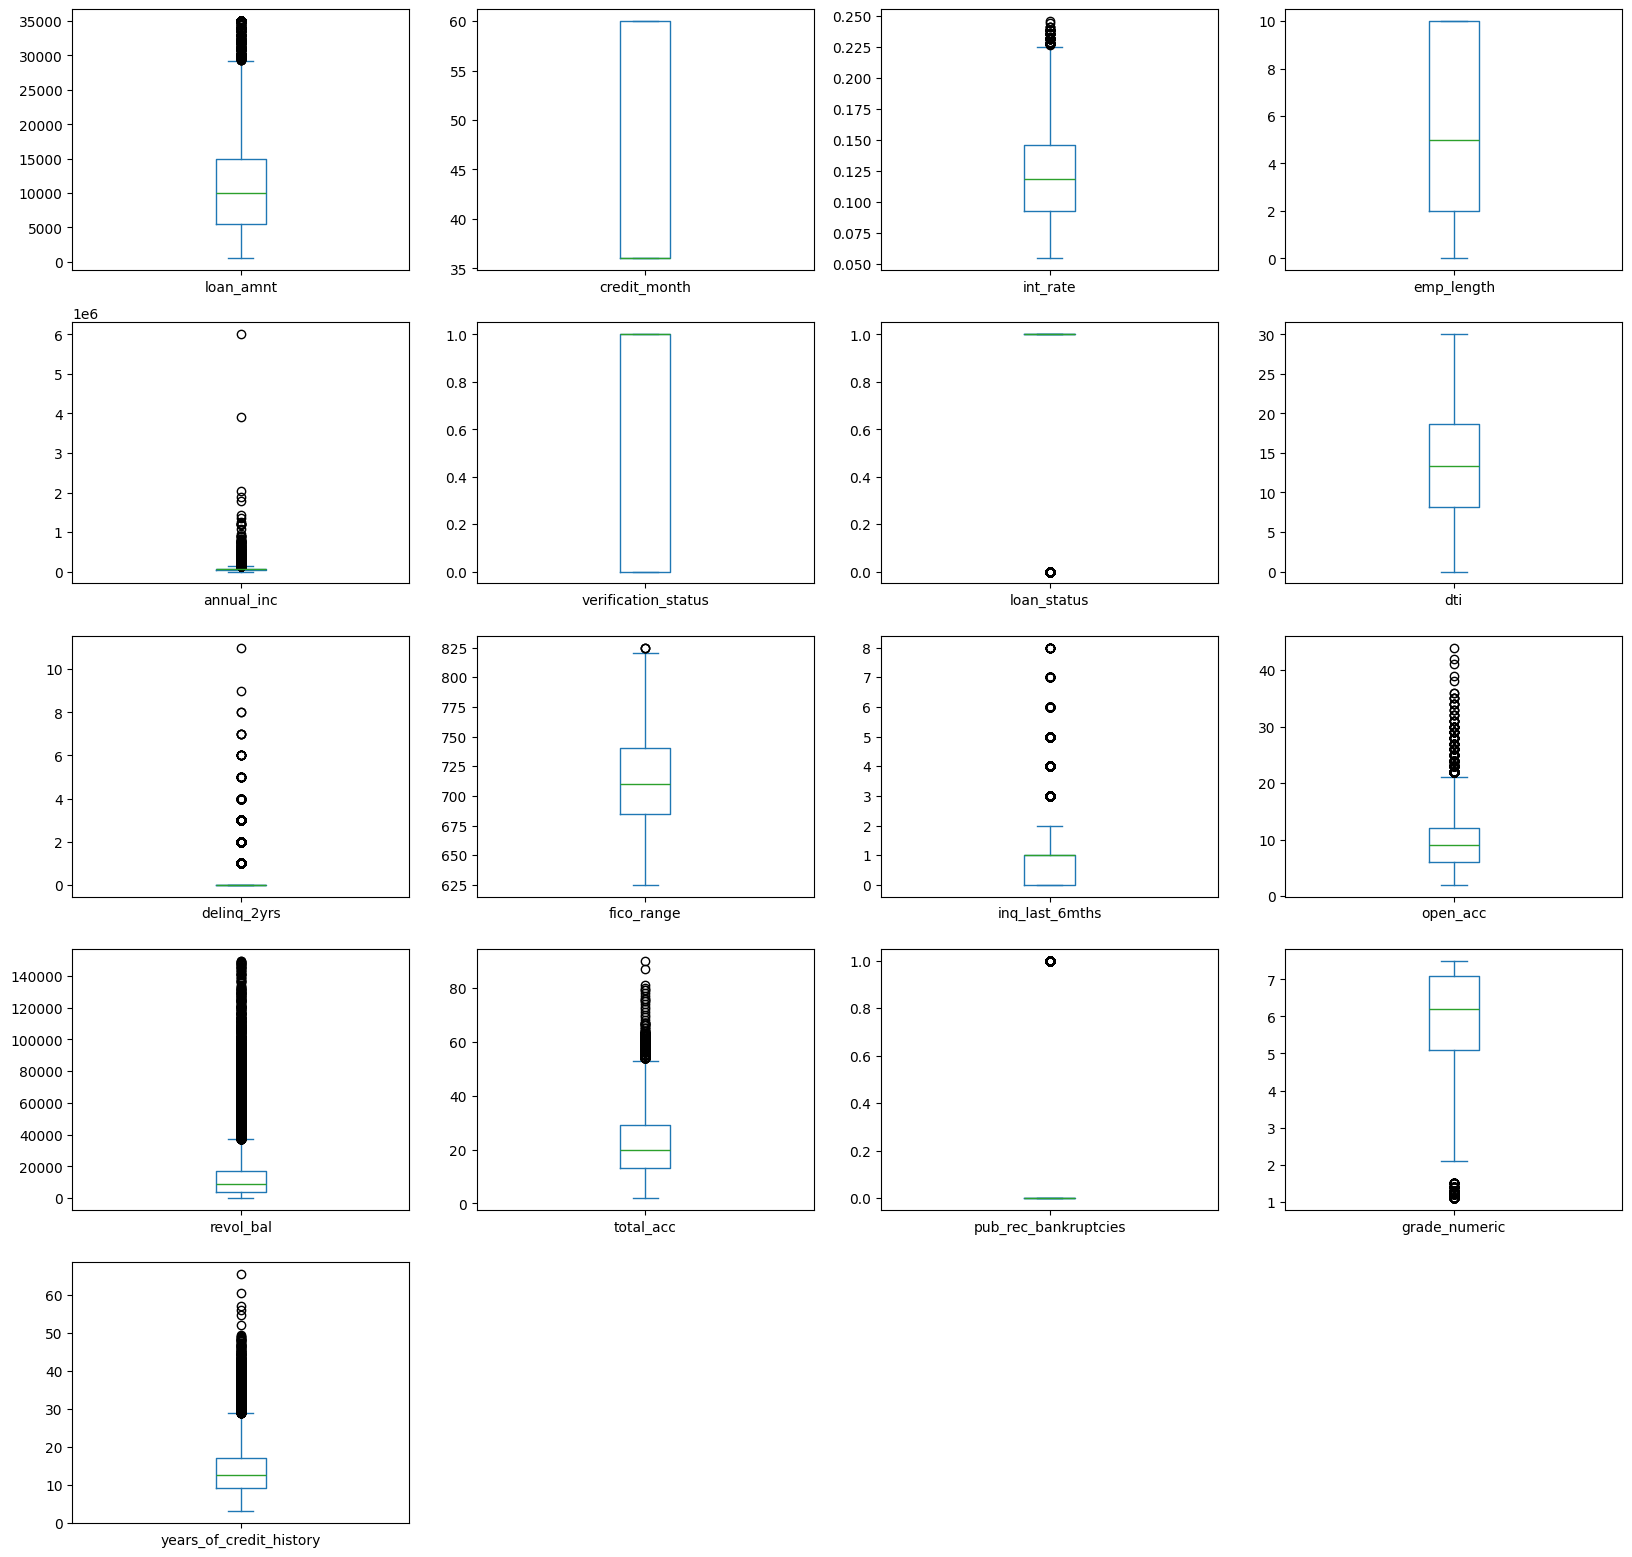

In [23]:
# Plot the date to check for outliers
df[df.columns].plot(kind='box', subplots=True,figsize=(20, 40), layout=(10,4),sharex=False, sharey=False)

In [24]:
# Remove outliers
def count_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers.shape[0]
# Set the threshold for the number of outliers
outlier_threshold = 1

# Check for outliers in each column
for column in df.columns:
    if np.issubdtype(df[column].dtype, np.number):
        num_outliers = count_outliers(df[column])
        if num_outliers > outlier_threshold:
            print(f"Kolumna '{column}' ma {num_outliers} outlierów.")

Kolumna 'loan_amnt' ma 1239 outlierów.
Kolumna 'int_rate' ma 78 outlierów.
Kolumna 'annual_inc' ma 1848 outlierów.
Kolumna 'loan_status' ma 5670 outlierów.
Kolumna 'delinq_2yrs' ma 4320 outlierów.
Kolumna 'fico_range' ma 3 outlierów.
Kolumna 'inq_last_6mths' ma 3639 outlierów.
Kolumna 'open_acc' ma 516 outlierów.
Kolumna 'revol_bal' ma 2500 outlierów.
Kolumna 'total_acc' ma 526 outlierów.
Kolumna 'pub_rec_bankruptcies' ma 2034 outlierów.
Kolumna 'grade_numeric' ma 318 outlierów.
Kolumna 'years_of_credit_history' ma 1379 outlierów.


In [25]:
# Winsorize the columns with outliers
for column in df.columns:
    if np.issubdtype(df[column].dtype, np.number):
        num_outliers = count_outliers(df[column])
        if num_outliers > outlier_threshold:
            winsorized_values = winsorize(df[column], limits=[0.05, 0.05])  
            df[column] = winsorized_values
            print(f"Column '{column}' has been winsorized.")

Column 'loan_amnt' has been winsorized.
Column 'int_rate' has been winsorized.
Column 'annual_inc' has been winsorized.
Column 'loan_status' has been winsorized.
Column 'delinq_2yrs' has been winsorized.
Column 'fico_range' has been winsorized.
Column 'inq_last_6mths' has been winsorized.
Column 'open_acc' has been winsorized.
Column 'revol_bal' has been winsorized.
Column 'total_acc' has been winsorized.
Column 'pub_rec_bankruptcies' has been winsorized.
Column 'grade_numeric' has been winsorized.
Column 'years_of_credit_history' has been winsorized.


loan_amnt                     Axes(0.125,0.814746;0.168478x0.0652542)
credit_month               Axes(0.327174,0.814746;0.168478x0.0652542)
int_rate                   Axes(0.529348,0.814746;0.168478x0.0652542)
emp_length                 Axes(0.731522,0.814746;0.168478x0.0652542)
annual_inc                    Axes(0.125,0.736441;0.168478x0.0652542)
verification_status        Axes(0.327174,0.736441;0.168478x0.0652542)
loan_status                Axes(0.529348,0.736441;0.168478x0.0652542)
dti                        Axes(0.731522,0.736441;0.168478x0.0652542)
delinq_2yrs                   Axes(0.125,0.658136;0.168478x0.0652542)
fico_range                 Axes(0.327174,0.658136;0.168478x0.0652542)
inq_last_6mths             Axes(0.529348,0.658136;0.168478x0.0652542)
open_acc                   Axes(0.731522,0.658136;0.168478x0.0652542)
revol_bal                     Axes(0.125,0.579831;0.168478x0.0652542)
total_acc                  Axes(0.327174,0.579831;0.168478x0.0652542)
pub_rec_bankruptcies

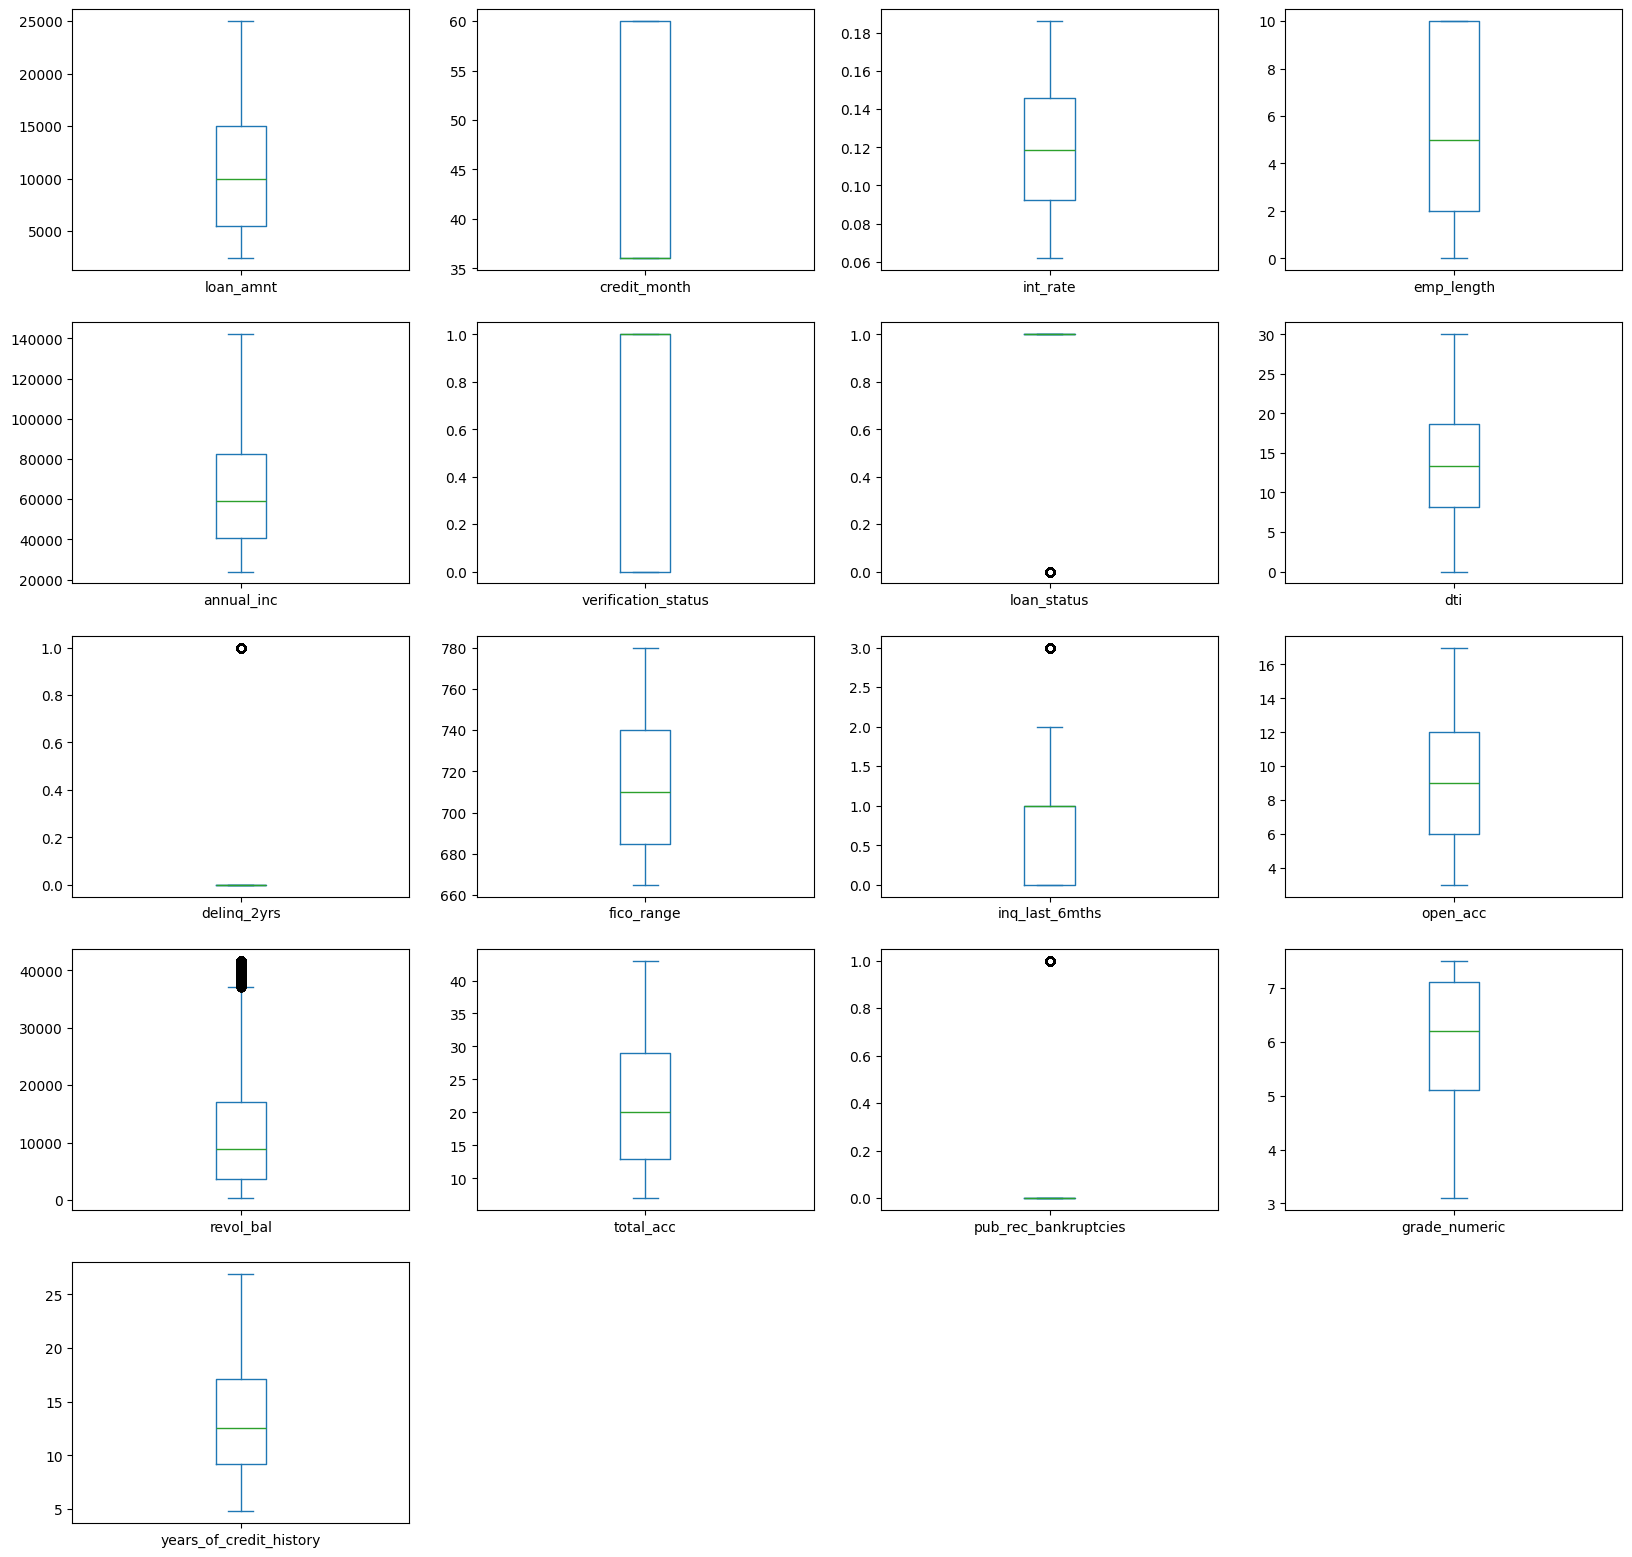

In [26]:
df[df.columns].plot(kind='box', subplots=True,figsize=(20, 40), layout=(10,4),sharex=False, sharey=False)

In [27]:
# Convert the columns "home_ownership" and "purpose" to dummy variables
df = pd.get_dummies(df, columns = ['home_ownership', 'purpose'], dtype = int)
df.head()

,loan_amnt,credit_month,int_rate,emp_length,annual_inc,verification_status,loan_status,dti,delinq_2yrs,fico_range,inq_last_6mths,open_acc,revol_bal,total_acc,pub_rec_bankruptcies,grade_numeric,years_of_credit_history,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other
0,5000.0,36,0.1065,10.0,24000.0,1,1,27.65,0.0,735.0,1.0,3.0,13648.0,9.0,0.0,6.2,26.9,0,0,0,1,1,0,0,0,0
1,2500.0,60,0.1527,0.0,30000.0,1,0,1.00,0.0,740.0,3.0,3.0,1687.0,7.0,0.0,5.4,12.7,0,0,0,1,0,0,0,0,1
2,2400.0,36,0.1596,10.0,24000.0,0,1,8.72,0.0,735.0,2.0,3.0,2956.0,10.0,0.0,5.5,10.1,0,0,0,1,0,0,0,0,1
3,10000.0,36,0.1349,10.0,49200.0,1,1,20.00,0.0,690.0,1.0,10.0,5598.0,37.0,0.0,5.1,15.8,0,0,0,1,0,0,0,0,1
4,3000.0,60,0.1269,1.0,80000.0,1,1,17.94,0.0,695.0,0.0,15.0,27783.0,38.0,0.0,6.5,15.9,0,0,0,1,0,0,0,0,1


In [28]:
# Save the cleaned data for modeling
df.to_csv('modeling_data.csv')